# Deep Learning: Coursework 3

------------------------------------------------------

**Student Name:**  Oliver Wesely (Student Number: 18057603 )

**Start date:** *26th March 2019*

**Due date:** *29th April 2019, 09:00 am *

------------------------------------------------------


## How to Submit

When you have completed the exercises and everything has finished running, click on 'File' in the menu-bar and then 'Download .ipynb'. This file must be submitted to Moodle named as **studentnumber_DL_cw3.ipynb** before the deadline above.

Please produce a **pdf** with all the **results** (tables and plots) as well as the **answers** to the questions below. For this assignment, you don't need to include any of the code in the pdf, but answers to the questions should be self-contained and should not rely on a code reference.  **Page limit: 20 pg.**

### IMPORTANT
Please make sure your submission includes **all results/answers/plots/tables** required for grading. We should not have to re-run your code.

### Credits
A special thank you to Mihaela Rosca, Shakir Mohammend and Andriy Mnih for their help in this coursework.

# Assignment Description 
(Latent Generative Models)


## Topics and optimization techniques covered: 

* Stochastic variational inference
* Amortized variational inference (VAEs)
* Improving amortized variational inference using KL annealing
* Improving amortized variational inference using constraint optimization
* Avoiding latent space distribution matching using GANs


## Tensorflow

**Note: ** Before taking on this assignment you might find it useful to take a look at the `tensorflow_probability` [package](https://www.tensorflow.org/probability), especially if you have not used probability distributions in TensorFlow before. In this assignment we will use only standard probability distribtions (like Gaussian and Bernouli), but worth taking a look on how TF handles in-graph sampling and optimizations involving distributions.

In [0]:
#@title Imports (Do not modify!)

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import math

import tensorflow as tf

import numpy as np

# Plotting library.
from matplotlib import pyplot as plt
import seaborn as sns

sns.set(rc={"lines.linewidth": 2.8}, font_scale=2)
sns.set_style("whitegrid")

# Tensorflow probability utilities
import tensorflow_probability as tfp

tfd = tfp.distributions

import warnings
warnings.filterwarnings('ignore')

In [144]:
#@title Check you're using the GPU (Expand me for instructions)
# Don't forget to select GPU runtime environment in Runtime -> Change runtime type
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Helper Functions for visualisation


In [0]:
def gallery(array, ncols=10, rescale=False):
    """Data visualization code."""
    if rescale:
      array = (array + 1.) / 2
    nindex, height, width, intensity = array.shape
    nrows = nindex//ncols
    assert nindex == nrows*ncols
    # want result.shape = (height*nrows, width*ncols, intensity)
    result = (array.reshape(nrows, ncols, height, width, intensity)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols, intensity))
    return result

In [0]:
def show_digits(axis, digits, title=''):
  axis.axis('off')
  ncols = int(np.sqrt(digits.shape[0]))
  axis.imshow(gallery(digits, ncols=ncols).squeeze(axis=2), 
                 cmap='gray')
  axis.set_title(title, fontsize=15)

In [0]:
def show_latent_interpolations(generator, prior, session):
  a = np.linspace(0.0, 1.0, BATCH_SIZE)
  a = np.expand_dims(a, axis=1)

  first_latents = prior.sample()[0]
  second_latents = prior.sample()[0]

  # To ensure that the interpolation is still likely under the Gaussian prior,
  # we use Gaussian interpolation - rather than linear interpolation.
  interpolations =  np.sqrt(a) * first_latents + np.sqrt(1 - a) * second_latents

  ncols = int(np.sqrt(BATCH_SIZE))
  samples_from_interpolations = generator(interpolations)
  samples_from_interpolations_np = sess.run(samples_from_interpolations)
  plt.gray()
  axis = plt.gca()
  show_digits(
     axis, samples_from_interpolations_np, title='Latent space interpolations')

## Hyperparameters (Do not modify!)
These were chosen to work across all models you are going to be training. At times you will need to explore other configuration to answer the questions, but keep this as default -- things should train nicely under these parameters! Check your model and gradients if that is not the case! 

In [0]:
BATCH_SIZE = 64
NUM_LATENTS = 10
TRAINING_STEPS = 10000

In [0]:
tf.reset_default_graph()

## The Data

### Handwritten Digit Recognition Dataset (MNIST)


We will be revisiting the [MNIST digit dataset](https://yann.lecun.com/exdb/mnist/) for this assignment. The setup/processing of the data will be a bit different in this assignment as for training purposes it is sometimes easier to expose the data sampling as an operation in the graph, rather than going through placeholders. This is in general a very useful way of handling data in tensorflow, especially for larger training regimes where 'stepping out' of the graph might be very expensive.

In the following we will walk you through how to get the data into this form. You do not need to worry about it, but it is worth making sure you understand the step, as this is something that might be useful to replicate in the future.
 


In [150]:
mnist = tf.contrib.learn.datasets.load_dataset("mnist")

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


In [151]:
print(mnist.train.images.shape)
print(type(mnist.train.images))

(55000, 784)
<type 'numpy.ndarray'>


### Transform the data from numpy arrays to in graph tensors.

This allows us to use TensorFlow datasets, which ensure that a new batch from the data is being fed at each session.run. This means that we do not need to use feed_dicts to feed data to each session.

In [0]:
def make_tf_data_batch(np_data, shuffle=True):  
  # Reshape the data to image size.
  images = np_data.reshape((-1, 28, 28, 1))
  
  # Create the TF dataset.   
  dataset = tf.data.Dataset.from_tensor_slices(images)
  
  # Shuffle and repeat the dataset for training.
  # This is required because we want to do multiple passes through the entire
  # dataset when training.
  if shuffle:
    dataset = dataset.shuffle(100000).repeat()
    
  # Batch the data and return the data batch.
  one_shot_iterator = dataset.batch(BATCH_SIZE).make_one_shot_iterator()
  data_batch = one_shot_iterator.get_next()
  return data_batch

In [153]:
real_data = make_tf_data_batch(mnist.train.images)
print(real_data.shape)

(?, 28, 28, 1)


# Part 1: Latent Variable models and Variational Inference



## T1.1 Stochastic Variational Inference

In this first task we will consider a simple latent variable model $z \rightarrow x$. Your task is to use stochastic variational inference to train a generative model on the MNIST data. For each data point $x_i$, there is a set of variational parameters to be learned. Throughout this assessment, the posterior and the prior will be Normal random variables, with uncorrelated dimensions.


Objective - maximize: 
\begin{equation}
 \mathbb{E}_{p^*(x)} \mathbb{E}_{q(z|x)}{\left[ \log p_\theta(x|z)\right]}  - \mathbb{E}_{p^*(x)} \left[KL(q(z|x)||p(z))\right]
\end{equation}

For more information, please check out:
 * http://www.columbia.edu/~jwp2128/Papers/HoffmanBleiWangPaisley2013.pdf

**Task**: Implement and train this model to generate MNIST digits. Visualise the results and answer the questions at the end of the section.

## Model Implementation

In the following, I am going to walk you through implementing this model. This will only be done for the first task, but you can use this to structure your code for all of the tasks after this. Also worth taking a look at question 1 at the end of this section before finishing the implementation - this should give you exactly what you have to implement in the update operations and training loop.

### Data variable

We will do multiple session.run to update the variational parameters for one data batch.
To ensure that the same batch is used, we define a variable for the data, and update it after updating the decoder parameters.

In [0]:
data_var = tf.Variable(
      tf.ones(shape=(BATCH_SIZE, 28, 28, 1), dtype=tf.float32), 
      trainable=False)

data_assign_op = tf.assign(data_var, real_data)

### Define the decoder

In [0]:
DECODER_VARIABLE_SCOPE = "decoder"

In [0]:
def standard_decoder(z):
  with tf.variable_scope(DECODER_VARIABLE_SCOPE, reuse=tf.AUTO_REUSE):
    h = tf.layers.dense(z, 7 * 7 * 64, activation=tf.nn.relu)
    h = tf.reshape(h, shape=[BATCH_SIZE, 7, 7, 64])
    h = tf.layers.Conv2DTranspose(
          filters=32,
          kernel_size=5,
          strides=2,
          activation=tf.nn.relu,
          padding='same')(h)
    h = tf.layers.Conv2DTranspose(
          filters=1,
          kernel_size=5,
          strides=2,
          activation=None,  # Do not activate the last layer.
          padding='same')(h)
    return tf.distributions.Bernoulli(h)

In [0]:
decoder = standard_decoder

### Define prior

In [0]:
def multi_normal(loc, log_scale):
  # We model the latent variables as independent
  return tfd.Independent(
      distribution=tfd.Normal(loc=loc, scale=tf.exp(log_scale)),
      reinterpreted_batch_ndims=1)
      
def make_prior():
  # Zero mean, unit variance prior.
  prior_mean = tf.zeros(shape=(BATCH_SIZE, NUM_LATENTS), dtype=tf.float32)
  prior_log_scale = tf.zeros(shape=(BATCH_SIZE, NUM_LATENTS), dtype=tf.float32)

  return multi_normal(prior_mean, prior_log_scale)

In [0]:
prior = make_prior()

### Define variational posterior $q(z|x)$

Define this to be a multi-dimensional Gaussian distribution. You can use the helper function above for this, but keep in mind the parameters of this distribution (mean and variance) ought to be trained.

In [0]:
# Build the variational posterior

var_mean = tf.get_variable('var_mean',shape=[BATCH_SIZE,NUM_LATENTS], trainable = True, dtype = tf.float32)
var_scale = tf.get_variable('var_scale',shape=[BATCH_SIZE,NUM_LATENTS], trainable = True, dtype = tf.float32)

variational_posterior = multi_normal(var_mean,var_scale)

### Define and build optimization objective (ELBO)

Putting things together: build the likelihood term and the KL term in the objective in (T1.1) description. 

In [0]:
def bound_terms(data_batch, variational_posterior, decoder_fn):

  # Sample posterior
  app_posterior_sample = variational_posterior.sample()
  
  # decoder
  likelihood_term = decoder_fn(app_posterior_sample).log_prob(data_batch)
  
  # Reduce sum
  likelihood_term = tf.reduce_sum(likelihood_term, [1,2,3])
  
  # Reduce mean over the batch dimensions
  likelihood_term = tf.reduce_mean(likelihood_term)

  # KL(q(z|x)||p(z))
  kl_term = tf.distributions.kl_divergence(variational_posterior, prior)
  
  # Reduce over the batch dimension.
  kl_term = tf.reduce_mean(kl_term)
  
  # Return the terms in the optimization objective in (1.1) description
  return likelihood_term, kl_term

In [0]:
# Maximize the data likelihodd and minimize the KL divergence between the prior and posterior
likelihood_term, kl_term = bound_terms(data_var, variational_posterior, decoder)
train_elbo = likelihood_term - kl_term

loss=-train_elbo

### Build the update operations for the variational and global variables

In [163]:
# Variational variable optimizer
variational_vars_optimizer = tf.train.GradientDescentOptimizer(0.05)

variational_vars = [var_mean,var_scale]

# Just to check
print('Variational vars" {}'.format(variational_vars))
variational_vars_update_op = variational_vars_optimizer.minimize(
      loss, var_list=variational_vars)


# Decoder optimizer
decoder_optimizer = tf.train.AdamOptimizer(0.001, beta1=0.9, beta2=0.9)
decoder_vars = tf.get_collection(
    tf.GraphKeys.TRAINABLE_VARIABLES, scope=DECODER_VARIABLE_SCOPE)
print('Decoder vars" {}'.format(decoder_vars))
decoder_update_op = decoder_optimizer.minimize(loss, var_list=decoder_vars)

Variational vars" [<tf.Variable 'var_mean:0' shape=(64, 10) dtype=float32_ref>, <tf.Variable 'var_scale:0' shape=(64, 10) dtype=float32_ref>]
Decoder vars" [<tf.Variable 'decoder/dense/kernel:0' shape=(10, 3136) dtype=float32_ref>, <tf.Variable 'decoder/dense/bias:0' shape=(3136,) dtype=float32_ref>, <tf.Variable 'decoder/conv2d_transpose/kernel:0' shape=(5, 5, 32, 64) dtype=float32_ref>, <tf.Variable 'decoder/conv2d_transpose/bias:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'decoder/conv2d_transpose_1/kernel:0' shape=(5, 5, 1, 32) dtype=float32_ref>, <tf.Variable 'decoder/conv2d_transpose_1/bias:0' shape=(1,) dtype=float32_ref>]


In [164]:
# Check trainable variables
tf.trainable_variables()

[<tf.Variable 'var_mean:0' shape=(64, 10) dtype=float32_ref>,
 <tf.Variable 'var_scale:0' shape=(64, 10) dtype=float32_ref>,
 <tf.Variable 'decoder/dense/kernel:0' shape=(10, 3136) dtype=float32_ref>,
 <tf.Variable 'decoder/dense/bias:0' shape=(3136,) dtype=float32_ref>,
 <tf.Variable 'decoder/conv2d_transpose/kernel:0' shape=(5, 5, 32, 64) dtype=float32_ref>,
 <tf.Variable 'decoder/conv2d_transpose/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'decoder/conv2d_transpose_1/kernel:0' shape=(5, 5, 1, 32) dtype=float32_ref>,
 <tf.Variable 'decoder/conv2d_transpose_1/bias:0' shape=(1,) dtype=float32_ref>]

### Training loop

In [0]:
# Number of SVI updates per sample
NUM_SVI_UPDATES = 50

In [0]:
sess = tf.Session()

# Initialize all variables
sess.run(tf.global_variables_initializer())

In [167]:
# %hide_pyerr  # - uncomment to interrupt training without a stacktrace
losses = []
kls = []
likelihood_terms = []

for i in xrange(TRAINING_STEPS):
  
  # Update the data batch.
  sess.run(data_assign_op)

  # Training (put things together based on the operations you've defined before)
  for t in range(NUM_SVI_UPDATES):
    sess.run([variational_vars_update_op])
  sess.run([decoder_update_op])
  
  # Report the loss and the kl once in a while.
  if i % 10 == 0:
    iteration_loss, iteration_kl, iteration_likelihood = sess.run(
          [loss, kl_term, likelihood_term])
    print('Iteration {}. Loss {}. KL {}'.format(
          i, iteration_loss, iteration_kl))
    losses.append(iteration_loss)
    kls.append(iteration_kl)
    likelihood_terms.append(iteration_likelihood)


Iteration 0. Loss 540.359619141. KL 0.354375272989
Iteration 10. Loss 451.77331543. KL 9.41325569153
Iteration 20. Loss 356.01184082. KL 6.33136796951
Iteration 30. Loss 283.844940186. KL 3.64028191566
Iteration 40. Loss 247.975112915. KL 6.55918312073
Iteration 50. Loss 227.740234375. KL 6.13982582092
Iteration 60. Loss 216.823822021. KL 4.89476490021
Iteration 70. Loss 205.159439087. KL 3.8680267334
Iteration 80. Loss 204.323181152. KL 3.54611301422
Iteration 90. Loss 212.592712402. KL 3.31741285324
Iteration 100. Loss 204.891082764. KL 3.20021009445
Iteration 110. Loss 211.660110474. KL 3.36144971848
Iteration 120. Loss 205.013427734. KL 3.43041491508
Iteration 130. Loss 207.64894104. KL 3.5492041111
Iteration 140. Loss 210.666244507. KL 3.80022525787
Iteration 150. Loss 198.092498779. KL 3.92614507675
Iteration 160. Loss 201.947525024. KL 4.20492982864
Iteration 170. Loss 206.702819824. KL 4.60260295868
Iteration 180. Loss 199.559799194. KL 4.83480978012
Iteration 190. Loss 201.627

## Results

Let us take a look at the optimization process and the resulting model

### Visualize training process

Plot the loss and KL over the training process (number of iterations)

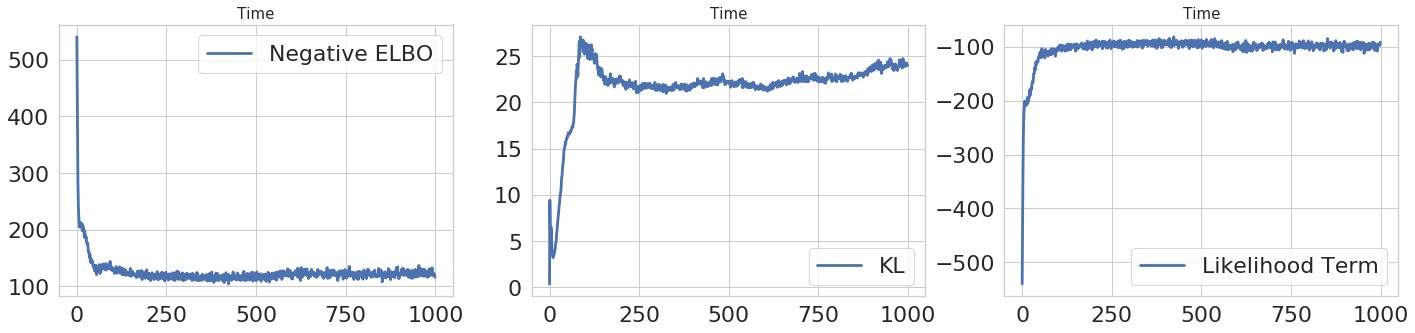

In [168]:
fig, axes = plt.subplots(1, 3, figsize=(3*8,5))

axes[0].plot(losses, label='Negative ELBO')
axes[0].set_title('Time', fontsize=15)
axes[0].legend()

axes[1].plot(kls, label='KL')
axes[1].set_title('Time', fontsize=15)
axes[1].legend()

axes[2].plot(likelihood_terms, label='Likelihood Term')
axes[2].set_title('Time', fontsize=15)
axes[2].legend()

### Generate samples, reconstructions and latent interpolation

In [0]:
# Read data (just sample from the data set)
# real_data_examples
samples = decoder(prior.sample()).mean()
samples.shape.assert_is_compatible_with([BATCH_SIZE,28,28,1])

# Note: the reconstructions are only valid after the inner loop optimization has
# been performed.
recon = decoder(variational_posterior.sample()).mean()

In [170]:
# Sample from the generative model!
def reset_ops():
  posterior_mean = (tf.ones(shape=(BATCH_SIZE, NUM_LATENTS), dtype=tf.float32))
  posterior_log_scale = (tf.ones(shape=(BATCH_SIZE, NUM_LATENTS), dtype=tf.float32))
  
  return posterior_mean, posterior_log_scale

variational_variables_reset_ops = reset_ops()


# For reconstructions, we run the inner loop updates first.
sess.run(data_assign_op)
  
# Reset the variational variables.
sess.run(variational_variables_reset_ops)

# Update the SVI variables.
for _ in range(1000):
  sess.run(variational_vars_update_op) 

(real_data_examples, data_reconstructions,
 variational_mean_val, variational_log_scale_val) = sess.run(
      [data_var, recon, var_mean, var_scale])

final_samples = sess.run(samples)
print(real_data_examples.shape)

(64, 28, 28, 1)


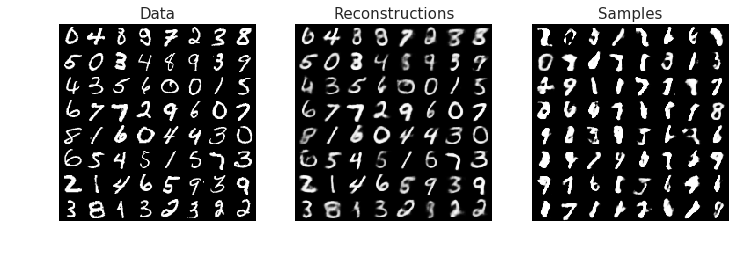

In [171]:
fig, axes = plt.subplots(1, 3, figsize=(3*4,4))

show_digits(axes[0], real_data_examples, 'Data')
show_digits(axes[1], data_reconstructions, 'Reconstructions')
show_digits(axes[2], final_samples, 'Samples')

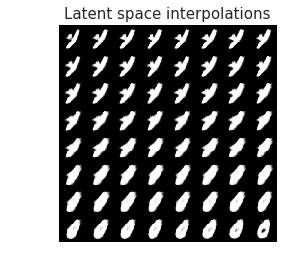

In [172]:
show_latent_interpolations(lambda x: decoder(x).mean(), prior, sess)

## Q1.1 VI Questions (28 pts):

We going to go through some questions on the model you have just implemented. The first question here could be answered before the implementation and can act as a blue-print for how to do the training. We are going to spend a bit more time on this first method as it is paramount you understand the optimization process here as a lot of the other tasks build on top of this one. 

Whenever a question asks for an effect/behaviour when varying one of the conditions, feel free to experiment. Both theoretical arguments and emperical plots showing the relevant behaviour will be accepted here.

1. **[5 pts]**  Derive the variational ELBO for **one** data point $x$ and explain how one would update the parameters for variational posterior $q_{\phi}(z|x)$, as well as the parameters of the generative distribution $p_{\theta}(x|z)$. Assume a Gaussian prior and a multi-dim Gaussian variational prior, as well as the generative function given  by the decoder in the code above. This is basically outlining the optimization you should be implementing in the **Training loop** section above. 


$$\log(p_{\theta}(x)) = \log\int_Z p_{\theta}(x,z)dz $$
$$\log(p_{\theta}(x)) = \log\int_Z q_{\phi}(z|x)\frac{p_{\theta}(x|z)p_{\theta}(z)}{q_{\phi}(z|x)} dz $$
$$\log(p_{\theta}(x)) \overset{Jensen}{\geq} \mathbb{E}_{q_{\phi}(z|x)}[\log(\frac{p_{\theta}(x|z)p_{\theta}(z)}{q_{\phi}(z|x)})] $$
$$ =  \mathbb{E}_{q_{\phi}(z|x)}[\log(p_{\theta}(x|z) + \log(\frac{p_{\theta}(z)}{q_{\phi}(z|x)})] $$
$$ = \mathbb{E}_{q_{\phi}(z|x)}[\log(p_{\theta}(x|z)]  + \int_{Z} q_{\phi}(z|x)\frac{p_{\theta}(z)}{q_{\phi}(z|x)} dz $$
$$ = \mathbb{E}_{q_{\phi}(z|x)}[\log(p_{\theta}(x|z)]  - KL(q_{\phi}(z|x) || p_{\theta}(z)) $$


$ \mathbb{E}_{p^{*}(x)} $ is the expected free energy under the distribution $p^{*}(x)$, which we will apply to the equation above:

$$ \mathbb{E}_{p^{*}(x)}\log(p_{\theta}(x)) =  \mathbb{E}_{p^{*}(x)}\mathbb{E}_{q_{\phi}(z|x)}[\log(p_{\theta}(x|z)]  - \mathbb{E}_{p^{*}(x)}KL(q_{\phi}(z|x) || p_{\theta}(z))$$

For updating parameters of the generative distribution we can get a closed form solution using a Bernoulli. We are also using function $f$ as a weight function of how much the latent variable $\mathbf{z}$  contributes to generate $\mathbf{x}$, in our case the CNN.

$$ p_{\theta}(\mathbf{x}|\mathbf{z}) \sim Bern(f(\mathbf{z}))$$

For updating parameters of the variational posterior, we can get a closed form solution defining our prior as to be a Gaussian/Normal, following:

$$ q_{\phi}(\mathbf{x}|\mathbf{z}) \sim Norm(f(\mathbf{x}), Trace[f(\mathbf{x})]) $$

2.  **[6 pts] **In the **Build the update operations for the variational and global variables**, I have define two separate optimizers for the two sets of parameters ($\theta$ and $\phi$). 
  * i)  How would you implement this with just one optimizer? (You just need to
explain how you would do it, but not implement).

Instead of the two separate optimizers for the two sets of parameters we could avoid those and rather optimize in one step by using the auto-encoding variational bayes algorithm which is basically a auto-encoder optimizing w.r.t. to both parameters at the same time.


  * ii) What happen if we change the variational variables' optimizer `variational_vars_optimizer` to `tf.train.AdamOptimizer`? (Feel free to experiment and change the learning rate accordingly) 

In general we see that SGD works better than Adam in a way that it doesn't converge to a local optimum that fast and secondly and more important Adam optimizer results in a posterior collapse, which means a local minimum has been reached, the posterior has the same distribution as the prior, so the latent variable is ignored. 


3. **[2 pts]** What are the computational considerents to think of when using SVI? What would happen if you would now want to train this SVI model on a big dataset, such as ImageNet? What part of this optimization process is mostly affected and in which way?

Using SVI, the number of SVI updates and the optimizer we use are the computational considerents. If we would use ImageNet as our dataset it would be computationally expensive, especially constructing the variational ELBO would cost us a lot more computational resources than with a smaller dataset, as we would have to evaluate/update parameters for every single pixel and ELBO evaluates log pdf's, which scale badly with increasing N

4. ** [2 pts]** What is the effect of the number of SVI updates on the ELBO and on the KL term?

Increasing the update would be computationally more expensive as we are repeating the update operations more often. Whereas, decreasing the number of updates would let the KL-divergence factor be very close to zero.

5. **[3 pts]** What is the effect of the data batch size on the convergence speed compared to the effect of the number of SVI updates? What is the effect of the number of training steps for the decoder compared to the number of SVI steps per decoder update?

Allthough a smaller batch size would increase  the computational time, as the gradient would get pretty small and noisy, it would still be tractable compared to increasing the number of SVI updates. Increasing the number of training steps of the decoder would make the computational costs even less compared to a smaller number of SVI updates and would get our predicted distribution closer to the true distribution.


**[10 pts] Model Implementation and Results**

## T1.2 Amortized Variational Inference

**Reminder**: The idea behind amortized inference is to replace the slow iterative optimization process we needed to do in the previous method for each data-point, with a faster non-iterative one.  Check the lecture slides and/or references below for more details.

Thus, instead of learning one set of posterior variables per data point, we can use function approximation to learn the distributional variables. Specifically, the posterior parameters for $x_i$ will be the output of a *learned* function $f_\theta(x_i)$, where $\theta$ are parameters now shared across all data points. Can you think of why this is useful?


<h2 align="center"></h2> <img src="http://elarosca.net/vae.png?format=100w" width=500 >


Objective - maximize: 
\begin{equation}
 \mathbb{E}_{p^*(x)} \mathbb{E}_{q(z|x)} {\left[ \log p_\theta(x|z) \right]}  - \mathbb{E}_{p^*(x)} \left[ KL(q(z|x)||p(z)) \right]
\end{equation}

For more information, please check out: 
  * https://arxiv.org/abs/1312.6114


**Task**: Implement and train this model to generate MNIST digits. Visualise the results and answer the questions at the end of the section.

## Model Implementation

In [0]:
tf.reset_default_graph()

In [34]:
real_data = make_tf_data_batch(mnist.train.images)
print(real_data.shape)

(?, 28, 28, 1)


### Define the encoder

In [0]:
ENCODER_VARIABLE_SCOPE = 'encoder'

In [0]:
def encoder(x):
  with tf.variable_scope(ENCODER_VARIABLE_SCOPE, reuse=tf.AUTO_REUSE):
    
    h = tf.layers.Conv2D(
          filters=8,
          kernel_size=5,
          strides=2,
          activation=tf.nn.relu,
          padding='same')(x)
    h = tf.layers.Conv2D(
          filters=16,
          kernel_size=5,
          strides=2,
          activation=tf.nn.relu,
          padding='same')(h)
    h = tf.layers.Conv2D(
          filters=32,
          kernel_size=5,
          strides=1,
          activation=tf.nn.relu,
          padding='same')(h)
    
    out_shape = 1
    for s in h.shape.as_list()[1:]:
      out_shape*= s
    
    h = tf.reshape(h, shape=[BATCH_SIZE, out_shape])
    mean = tf.layers.dense(h, NUM_LATENTS, activation=None)
    scale = tf.layers.dense(h, NUM_LATENTS, activation=None)
    return multi_normal(loc=mean, log_scale=scale)

### Define the prior

In [0]:
prior=make_prior()

### Define the variational posterior
**Note**: We no longer have to use a variable to store the data. We will perform one encoder update per decoder update, so it is OK for the data batch to be refreshed at each run.

In [0]:
variational_posterior=encoder(real_data)

### Define the decoder
We will use the same decoder as in T1.1

In [0]:
decoder = standard_decoder

### Define and build optimization objective (ELBO)

In [0]:
# Maximize the data likelihodd and minimize the KL divergence between the prior 
# and posterior. We use the exact same loss as in the SVI case.

likelihood_term, kl_term = bound_terms(real_data,variational_posterior,decoder)
train_elbo = likelihood_term - kl_term
loss =- train_elbo

### Define optimization and the update operations

In [0]:
optimizer = tf.train.AdamOptimizer(0.001, beta1=0.9, beta2=0.9)

update_op = optimizer.minimize(loss)

## Training

In [0]:
sess = tf.Session()

# Initialize all variables
sess.run(tf.global_variables_initializer())

In [47]:
# %hide_pyerr  # - uncomment to interrupt training without a stacktrace
losses = []
kls = []
likelihood_terms = []


for i in xrange(TRAINING_STEPS):
  
  sess.run([update_op])
  
  if i % 100 == 0:
    iteration_loss, iteration_likelihood, iteration_kl  = sess.run(
          [loss, likelihood_term, kl_term])
    print('Iteration {}. Loss {}. KL {}'.format(
          i, iteration_loss, iteration_kl))
    losses.append(iteration_loss)
    kls.append(iteration_kl)
    likelihood_terms.append(iteration_likelihood)

Iteration 0. Loss 538.387695312. KL 0.0344220623374
Iteration 100. Loss 208.289047241. KL 4.68742132187
Iteration 200. Loss 166.289428711. KL 9.80865097046
Iteration 300. Loss 147.922058105. KL 13.9706497192
Iteration 400. Loss 130.251205444. KL 16.3222084045
Iteration 500. Loss 127.068336487. KL 16.7629528046
Iteration 600. Loss 115.43926239. KL 18.0965023041
Iteration 700. Loss 123.143600464. KL 17.6678657532
Iteration 800. Loss 112.904548645. KL 17.088350296
Iteration 900. Loss 118.105621338. KL 17.5664539337
Iteration 1000. Loss 116.641860962. KL 17.8392505646
Iteration 1100. Loss 112.368232727. KL 17.796836853
Iteration 1200. Loss 115.432296753. KL 18.4580726624
Iteration 1300. Loss 113.407981873. KL 18.4296016693
Iteration 1400. Loss 110.581451416. KL 18.2567481995
Iteration 1500. Loss 110.363922119. KL 17.9384040833
Iteration 1600. Loss 111.967666626. KL 18.9745521545
Iteration 1700. Loss 113.830123901. KL 18.5947265625
Iteration 1800. Loss 111.715568542. KL 19.1748275757
Iterat

## Results

Let us take a look at the optimization process and the resulting model


### Visualize the loss in time

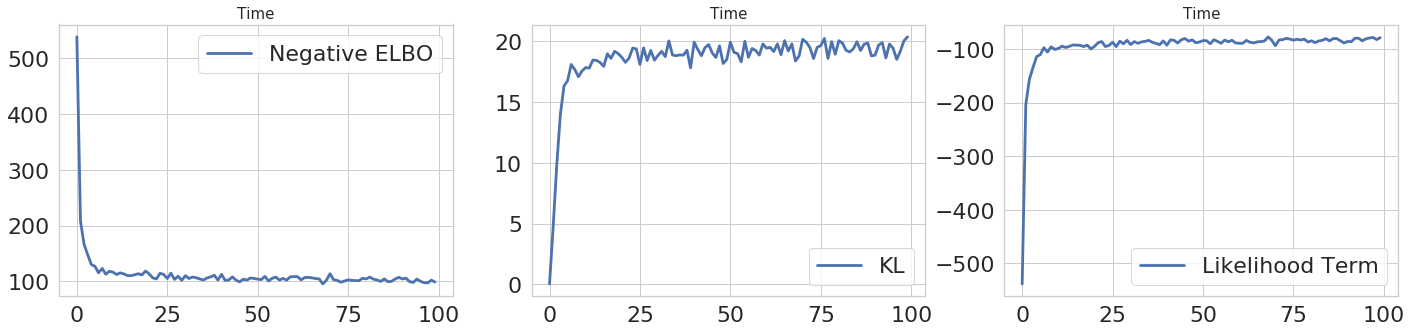

In [48]:
fig, axes = plt.subplots(1, 3, figsize=(3*8,5))

axes[0].plot(losses, label='Negative ELBO')
axes[0].set_title('Time', fontsize=15)
axes[0].legend()

axes[1].plot(kls, label='KL')
axes[1].set_title('Time', fontsize=15)
axes[1].legend()

axes[2].plot(likelihood_terms, label='Likelihood Term')
axes[2].set_title('Time', fontsize=15)
axes[2].legend()

### Generate samples and latent interpolations

In [0]:
samples = decoder(prior.sample()).mean()
samples.shape.assert_is_compatible_with([BATCH_SIZE, 28, 28, 1])

reconstructions = decoder(variational_posterior.sample()).mean()

In [0]:
real_data_vals, final_samples_vals, data_reconstructions_vals = sess.run(
      [real_data, samples, reconstructions])

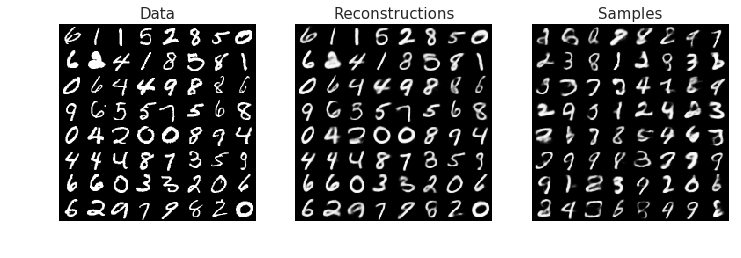

In [51]:
fig, axes = plt.subplots(1, 3, figsize=(3*4,4))


show_digits(axes[0], real_data_vals, 'Data')
show_digits(axes[1], data_reconstructions_vals, 'Reconstructions')
show_digits(axes[2], final_samples_vals, 'Samples')

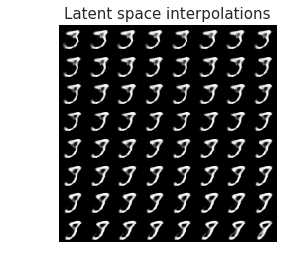

In [52]:
show_latent_interpolations(lambda x: decoder(x).mean(), prior, sess)

## Q1.2 Questions about Amortized Variational Inference (15 pts)

1. **[5 pts]** What do you notice about amortized variational inference (especially as compared with stochastic variational inference)? 
  * i) Are there any downsides to using the amortized version?
  
As of some parameteres will be shared between datapoints we can see a lot of reconstructions of the digits with similar patterns, which is the case due to less complexity in our model.
  
  * ii) What do you observe about sample quality and reconstruction quality?
  
The reconstruction quality is pretty good and we only find a few digits which resonably differ from their true/initial state. In contrast, the sample quality is doing a little worse and we identify some flatened areas and mixtures of different digits which are a bit unclear.
  
  * iii) What do you observe about the ELBO and KL term?
  
Using this settings we see that our KL has less jumps, especially at the beginning where we normally have big up and downs. The ELBO is also a lot smoother.
 
(Here, feel free to vary parameters and compare with the T1.1)

2. **[4 pts]** Stochastic and amortized variational inference can be combined, leading to semi-amortized variational inference. Give an instance of an algorithm that would combine these and explain why that would be useful?

I found a paper called "Semi-Amortized Variational Autoencoders" (Kim et al, 2018) where the authors main advantage of using this was to get rid of a posterior collapse, as seen before, and to get rid of a so called amortization gap, which Cramer et al mentioned in their paper "Inference Suboptimality in Variation Autoencoder" (2018).

3. **[1 pts]** What gradient estimation method is used to compute the gradients with respect to the encoder parameters?

We use AdamOptimizer (learning rate = 0.001, beta1=0.9, beta2=0.9)

**[5 pts] Model Implementation and Results**

## T1.3 KL annealing

In this section we are going to be looking at the same model as in **T2.1**: same encoder + decoder, prior. But we are going to change slightly the optimization objective as given below.

Objective - maximize: 
\begin{equation}
 \mathbb{E}_{p^*(x)} \mathbb{E}_{q(z|x) \log p_\theta(x|z)}  - \alpha \mathbb{E}_{p^*(x)} KL(q(z|x)||p(z))
\end{equation}

Where **$\alpha$ changes during training, to weigh in the KL term more**. In particular for our problem consider:
\begin{equation}
\alpha = \frac{n_{iter}}{N}
\end{equation}
where $n_{iter}$ is the number of training iterations we are have completed and $N$ is the total number of training iterations `TRAINING_STEPS`.

**Task**: Implement and train this model to generate MNIST digits. Visualise the results and answer the questions at the end of the section.

## Model Implementation

In [0]:
tf.reset_default_graph()

In [0]:
real_data = make_tf_data_batch(mnist.train.images)

In [0]:
prior = make_prior()
decoder = standard_decoder
encoder = encoder

variational_posterior = encoder(real_data)

### Define the KL coefficient $\alpha$ and its update function

In [0]:
kl_coefficient = tf.Variable(0,trainable=False,dtype=tf.float32)
kl_step = tf.constant(1/TRAINING_STEPS)

update_kl_coeff = tf.assign(kl_coefficient, kl_coefficient + kl_step)

In [0]:
likelihood_term, kl_term = bound_terms(real_data,variational_posterior,decoder)
train_elbo = likelihood_term - kl_coefficient*kl_term
loss =- train_elbo

In [0]:
# We now perform joint optimization on the encoder and decoder variables.
optimizer = tf.train.AdamOptimizer(0.001, beta1=0.9, beta2=0.9)

variables_update_op = optimizer.minimize(loss)

# Ensure that a variable update is followed by an update in the KL coefficient.
with tf.control_dependencies([variables_update_op]):
  update_op = tf.identity(update_kl_coeff)

## Training

In [59]:
sess = tf.Session()

# Initialize all variables
sess.run(tf.initialize_all_variables())

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [60]:
# %hide_pyerr  # - uncomment to interrupt training without a stacktrace
losses = []
kls = []
likelihood_terms = []


for i in xrange(TRAINING_STEPS):
  sess.run(update_op)
  
  if i % 100 == 0:
    iteration_loss, iteration_likelihood, iteration_kl  = sess.run(
          [loss, likelihood_term, kl_term])
    print('Iteration {}. Loss {}. KL {}'.format(
          i, iteration_loss, iteration_kl))
    losses.append(iteration_loss)
    kls.append(iteration_kl)
    likelihood_terms.append(iteration_likelihood)

Iteration 0. Loss 540.383666992. KL 0.0507474020123
Iteration 100. Loss 200.688781738. KL 58.07006073
Iteration 200. Loss 155.688064575. KL 63.3345870972
Iteration 300. Loss 125.329277039. KL 70.6425704956
Iteration 400. Loss 110.114349365. KL 56.1498908997
Iteration 500. Loss 107.95500946. KL 47.8330154419
Iteration 600. Loss 100.472740173. KL 45.6430206299
Iteration 700. Loss 97.7133102417. KL 40.4507598877
Iteration 800. Loss 104.673477173. KL 39.3737869263
Iteration 900. Loss 100.572273254. KL 36.7369918823
Iteration 1000. Loss 93.9901580811. KL 34.653793335
Iteration 1100. Loss 88.7126464844. KL 34.9497337341
Iteration 1200. Loss 91.3711624146. KL 32.4632720947
Iteration 1300. Loss 89.8643112183. KL 32.0988807678
Iteration 1400. Loss 95.0288162231. KL 32.6196746826
Iteration 1500. Loss 90.8512115479. KL 31.2392425537
Iteration 1600. Loss 96.5764923096. KL 30.0102272034
Iteration 1700. Loss 98.3172988892. KL 29.0507392883
Iteration 1800. Loss 90.2704391479. KL 29.1935043335
Iterati

## Results

Let us take a look at the optimization process and the resulting model

### Visualize training process

Plot the loss and KL and likelihood over the training process (number of iterations)

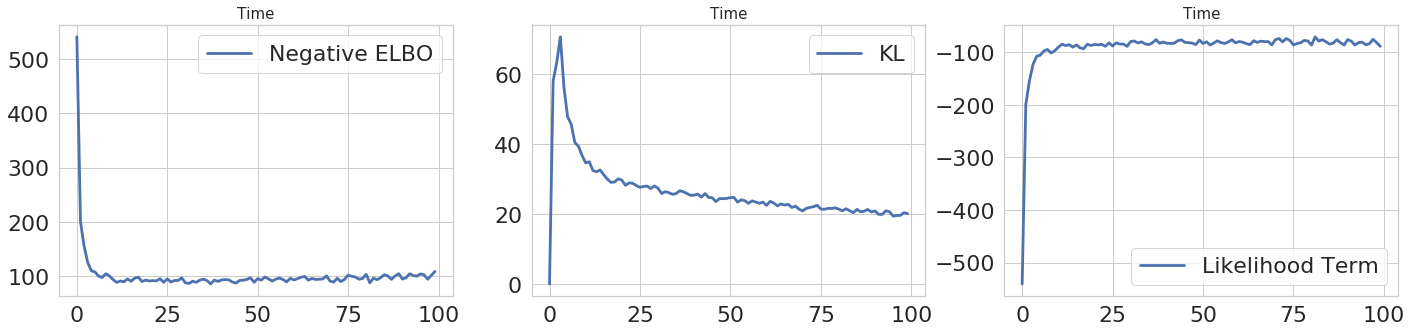

In [61]:
fig, axes = plt.subplots(1, 3, figsize=(3*8,5))

axes[0].plot(losses, label='Negative ELBO')
axes[0].set_title('Time', fontsize=15)
axes[0].legend()

axes[1].plot(kls, label='KL')
axes[1].set_title('Time', fontsize=15)
axes[1].legend()

axes[2].plot(likelihood_terms, label='Likelihood Term')
axes[2].set_title('Time', fontsize=15)
axes[2].legend()

### Generate samples, reconstructions and latent interpolation

In [0]:
samples = decoder(prior.sample()).mean()
samples.shape.assert_is_compatible_with([BATCH_SIZE, 28, 28, 1])

reconstructions = decoder(variational_posterior.sample()).mean()

In [0]:
real_data_vals, final_samples_vals, data_reconstructions_vals = sess.run(
      [real_data, samples, reconstructions])

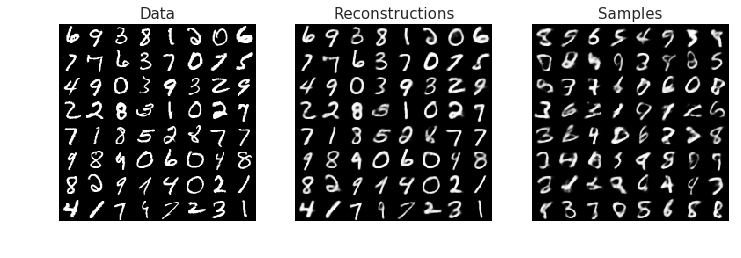

In [64]:
fig, axes = plt.subplots(1, 3, figsize=(3*4,4))


show_digits(axes[0], real_data_vals, 'Data')
show_digits(axes[1], data_reconstructions_vals, 'Reconstructions')
show_digits(axes[2], final_samples_vals, 'Samples')

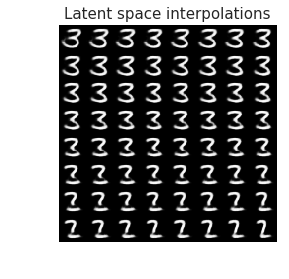

In [65]:
show_latent_interpolations(lambda x: decoder(x).mean(), prior, sess)

## Q1.3 Questions about KL annealing (15 pts):

1. **[3 pts]** What do you observe about the KL behaviour throughout training as opposed to amortized variational inference without any KL annealing? 

The KL of AVI is increasing quickly until it stays with a little variance around his final value. Whereas using KL annealing we se a big jump at the beginning and starting from a higher KL decreasing to its final value.

2.  **[1 pts]** How do the samples and reconstruction compare with the previous models?

Reconstructions seem to be a little better and are more precisely compared to previous models, even though our samples didn't improve compared to AVI but still are a little clearer than SVI.

3.  **[6 pts]** Consider now a schedule where $\alpha$ increases over time -- that is the contribution of the KL diminishes over time. When would that be a useful case? (Think about what this objective corresponds to in the optimization problem).

It might be usefull against the problem of posterior collapse. If we use KL annealing right away with a low $\alpha$ and increase it over time to converge to 1, then we would encode a lot at the beginning, whereas in the long run, when alpha is close to 1 the KL term will be getting more and more similar to the "normal" KL term.


**[5 pts] Model Implementation and Results**

## T1.4 Constrained optimization

In this next part, instead of using KL annealing, constrained optimization can be used to automatically tuned the relative weight of the likelihood and KL terms. This removes the need to manually create an optimization schedule, which can be problem specific.

The objective now becomes:

\begin{equation}
  \text{minimize } \mathbb{E}_{p^*(x)} KL(q(z|x)||p(z)) \text{ such that }  \mathbb{E}_{p^*(x)} \mathbb{E}_{q(z|x)} \left[ {\log p_\theta(x|z)} \right] > \alpha 
\end{equation}

This can be solved using the use of Lagrange multipliers. The objective becomes:

\begin{equation}
  \text{minimize }  \mathbb{E}_{p^*(x)} KL(q(z|x)||p(z)) + \lambda  (\mathbb{E}_{p^*(x)} \mathbb{E}_{q(z|x)} (\alpha - \log p_\theta(x|z)))
\end{equation}


The difference compared to the KL annealing is that:

   * $\lambda$ is a learned parameter - it will be learned using stochastic gradient descent, like the network parameters.  The difference is that the lagrangian has to solve a maximization problem. You can see this intuitively: the gradient with respect to $\lambda$ in the objective above is $\mathbb{E}_{p^*(x)} \mathbb{E}_{q(z|x)} (\alpha - \log p_\theta(x|z))$. If $ \mathbb{E}_{p^*(x)} \mathbb{E}_{q(z|x)} (\alpha - \log p_\theta(x|z))> 0$, the constraint is not being satisfied, so the value of the lagrangian needs to increase. This will be done by doing gradient ascent, instead of gradient descent. Note that for $\lambda$ to be a valid lagranian in a minimization problem, it has to be positive.
   * The practicioner has to specify the hyperparameter $\alpha$, which determines the reoncstruction quality of the model.
   * the coefficient is in front of the likelihood term, not the KL term. This is mainly for convenience, as it is easier to specify the hyperparameter $\alpha$ for the likelihood (reconstruction loss).


For more assumptions made by this method, see the Karush–Kuhn–Tucker conditions.

For more information, see: 
  * http://bayesiandeeplearning.org/2018/papers/33.pdf

**Task**: Implement and train this model to generate MNIST digits. Visualise the results and answer the questions at the end of the section.

## Model Implementation

In [0]:
tf.reset_default_graph()

In [0]:
real_data = make_tf_data_batch(mnist.train.images)

In [0]:
prior = make_prior()
decoder = standard_decoder
encoder = encoder

variational_posterior =encoder(real_data)

### Define the lagrangian variable $\lambda$.
Unlike in the KL annealing case, we learn the coefficient. Remember that this variable has to be always positive. To ensure this, use `tf.nn.softplus`, Moreover, please initialize the lagrangian such that after the softplus the coefficient is approximately 1. Check emperically that this is true when instantiating the variable.

In [0]:


lagrangian_var = tf.Variable(0.5,dtype=tf.float32)

# Ensure that the lagrangian is positive and has stable dynamics.
lagrangian = tf.nn.softplus(lagrangian_var)

In [0]:
# How good do we want the reconstruction loss to be?
# We can look at previous runs to get an idea what a reasonable value would be.

reconstruction_target =tf.constant(-80.0)

### Define the loss

In [0]:
likelihood_term, kl_term = bound_terms(real_data, variational_posterior, decoder)
loss =  kl_term + lagrangian * (reconstruction_target - likelihood_term )

In [134]:
# Check trainable variables (the lagrangian variable should be in here)
tf.trainable_variables()

[<tf.Variable 'encoder/conv2d/kernel:0' shape=(5, 5, 1, 8) dtype=float32_ref>,
 <tf.Variable 'encoder/conv2d/bias:0' shape=(8,) dtype=float32_ref>,
 <tf.Variable 'encoder/conv2d_1/kernel:0' shape=(5, 5, 8, 16) dtype=float32_ref>,
 <tf.Variable 'encoder/conv2d_1/bias:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 'encoder/conv2d_2/kernel:0' shape=(5, 5, 16, 32) dtype=float32_ref>,
 <tf.Variable 'encoder/conv2d_2/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'encoder/dense/kernel:0' shape=(1568, 10) dtype=float32_ref>,
 <tf.Variable 'encoder/dense/bias:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'encoder/dense_1/kernel:0' shape=(1568, 10) dtype=float32_ref>,
 <tf.Variable 'encoder/dense_1/bias:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'Variable:0' shape=() dtype=float32_ref>,
 <tf.Variable 'decoder/dense/kernel:0' shape=(10, 3136) dtype=float32_ref>,
 <tf.Variable 'decoder/dense/bias:0' shape=(3136,) dtype=float32_ref>,
 <tf.Variable 'decoder/conv2d_transpose/kernel

In [0]:
lagrangian_optimizer = tf.train.GradientDescentOptimizer(0.001)

enc_var=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope=ENCODER_VARIABLE_SCOPE)
dec_var=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope=DECODER_VARIABLE_SCOPE)
autoencoder_variables_update_op = optimizer.minimize(loss,var_list=[enc_var,dec_var])

# Ensure that a variable update is followed by an update to the Lagrangian.
with tf.control_dependencies([autoencoder_variables_update_op]):
  # Ensure that the lagrangian solves a maximization problem instead of a
  # minimization problem by changing the sign of the loss function.
  update_op = lagrangian_optimizer.minimize(- loss, var_list=[lagrangian_var])

## Training

In [0]:
sess = tf.Session()

# Initialize all variables
sess.run(tf.initialize_all_variables())

In [137]:
# %hide_pyerr  # - uncomment to interrupt training without a stacktrace
losses = []
kls = []
likelihood_terms = []
lagrangian_values = []

for i in xrange(TRAINING_STEPS):
  sess.run(update_op)
  
  
  if i % 100 == 0:
    iteration_loss, iteration_likelihood, iteration_kl, lag_val  = sess.run(
          [loss, likelihood_term, kl_term, lagrangian])
    print('Iteration {}. Loss {}. KL {}. Lagrangian {}'.format(
          i, iteration_loss, iteration_kl, lag_val))
    losses.append(iteration_loss)
    kls.append(iteration_kl)
    likelihood_terms.append(iteration_likelihood)
    lagrangian_values.append(lag_val)

Iteration 0. Loss 536.386535645. KL 0.019572712481. Lagrangian 1.16351425648
Iteration 100. Loss 2207.91796875. KL 24.2076053619. Lagrangian 19.3930931091
Iteration 200. Loss 2392.33569336. KL 37.9120597839. Lagrangian 29.3539485931
Iteration 300. Loss 1566.0534668. KL 55.6483764648. Lagrangian 34.7909088135
Iteration 400. Loss 1072.58728027. KL 57.8839874268. Lagrangian 37.9491004944
Iteration 500. Loss 683.231201172. KL 53.5594558716. Lagrangian 40.2174186707
Iteration 600. Loss 938.786193848. KL 56.5537757874. Lagrangian 42.0913200378
Iteration 700. Loss 887.790405273. KL 56.636428833. Lagrangian 43.6228561401
Iteration 800. Loss 1167.71484375. KL 49.5182952881. Lagrangian 44.990322113
Iteration 900. Loss 605.965026855. KL 52.4041137695. Lagrangian 46.1399612427
Iteration 1000. Loss 836.619384766. KL 52.8949661255. Lagrangian 47.217830658
Iteration 1100. Loss 851.755737305. KL 53.3342704773. Lagrangian 48.2055549622
Iteration 1200. Loss 404.775054932. KL 49.4334793091. Lagrangian 49

## Results

Let us take a look at the optimization process and the resulting model

### Visualize training process

Plot the loss and KL over the training process (number of iterations)

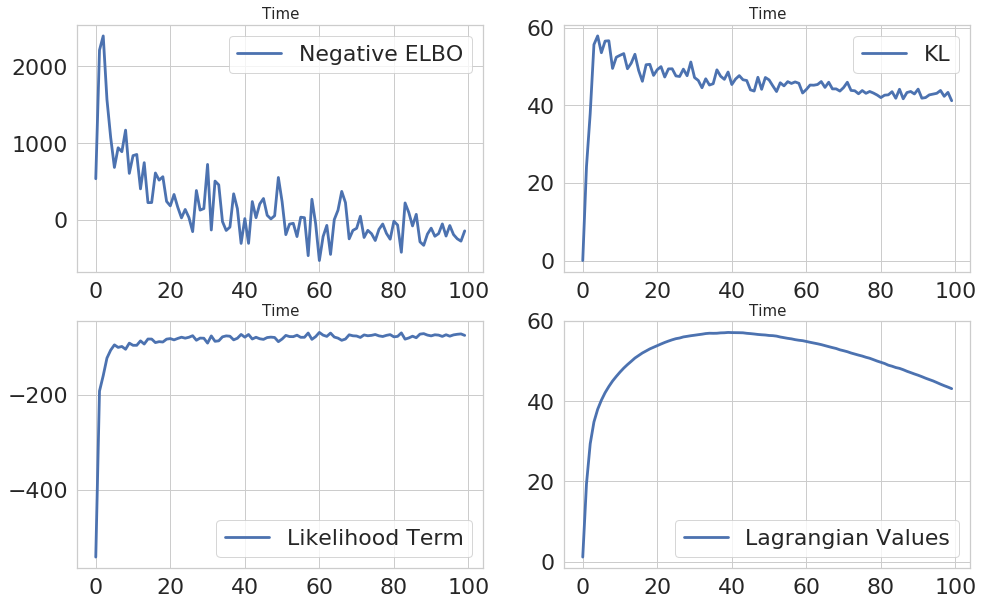

In [138]:
fig, axes = plt.subplots(2, 2, figsize=(2*8, 2* 5))

axes[0, 0].plot(losses, label='Negative ELBO')
axes[0, 0].set_title('Time', fontsize=15)
axes[0, 0].legend()

axes[0, 1].plot(kls, label='KL')
axes[0, 1].set_title('Time', fontsize=15)
axes[0, 1].legend()

axes[1, 0].plot(likelihood_terms, label='Likelihood Term')
axes[1, 0].set_title('Time', fontsize=15)
axes[1, 0].legend()

axes[1, 1].plot(lagrangian_values, label='Lagrangian Values')
axes[1, 1].set_title('Time', fontsize=15)
axes[1, 1].legend()

In [0]:
samples = decoder(prior.sample()).mean()
samples.shape.assert_is_compatible_with([BATCH_SIZE, 28, 28, 1])

reconstructions = decoder(variational_posterior.sample()).mean()

### Generate samples and latent interpolations

In [0]:
real_data_vals, final_samples_vals, data_reconstructions_vals = sess.run(
      [real_data, samples, reconstructions])

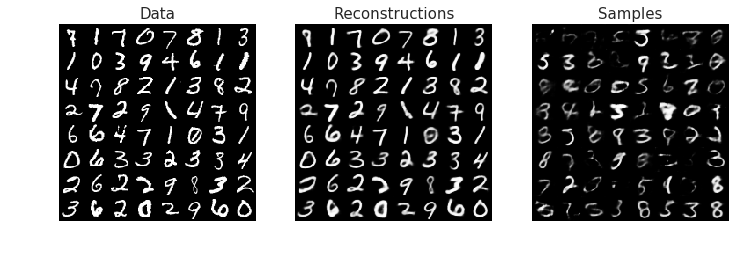

In [141]:
fig, axes = plt.subplots(1, 3, figsize=(3*4,4))


show_digits(axes[0], real_data_vals, 'Data')
show_digits(axes[1], data_reconstructions_vals, 'Reconstructions')
show_digits(axes[2], final_samples_vals, 'Samples')

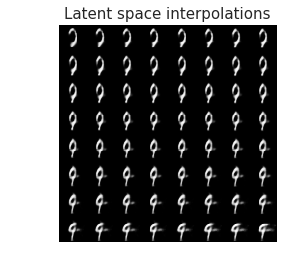

In [142]:
show_latent_interpolations(lambda x: decoder(x).mean(), prior, sess)

#### Reconstruction Target '-150':

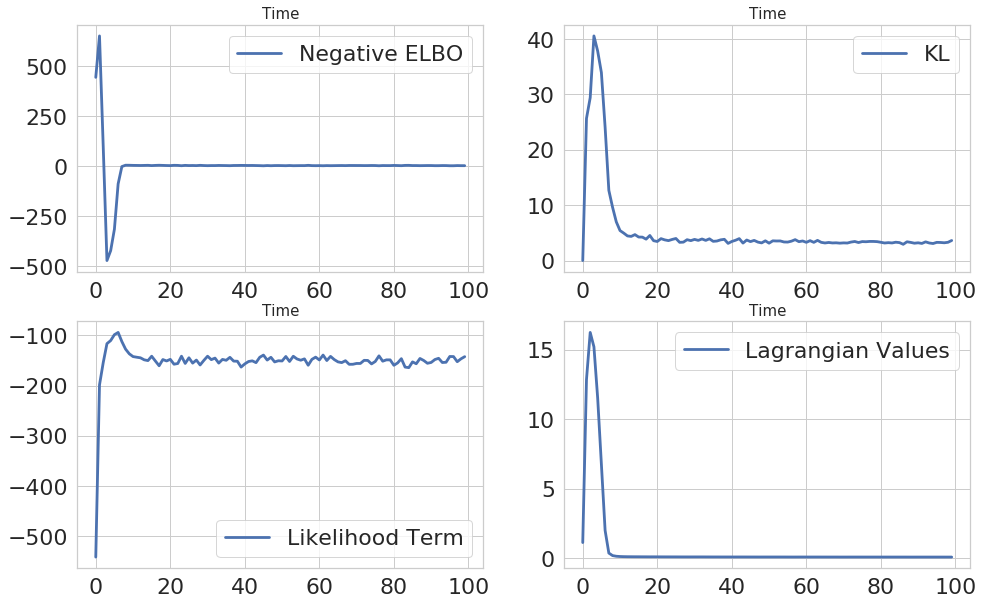

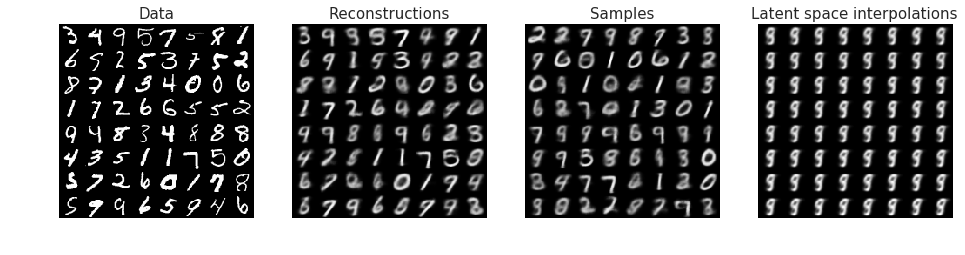

In [127]:
#Reconstruction target '-150':

fig, axes = plt.subplots(2, 2, figsize=(2*8, 2* 5))

axes[0, 0].plot(losses, label='Negative ELBO')
axes[0, 0].set_title('Time', fontsize=15)
axes[0, 0].legend()

axes[0, 1].plot(kls, label='KL')
axes[0, 1].set_title('Time', fontsize=15)
axes[0, 1].legend()

axes[1, 0].plot(likelihood_terms, label='Likelihood Term')
axes[1, 0].set_title('Time', fontsize=15)
axes[1, 0].legend()

axes[1, 1].plot(lagrangian_values, label='Lagrangian Values')
axes[1, 1].set_title('Time', fontsize=15)
axes[1, 1].legend()

samples = decoder(prior.sample()).mean()
samples.shape.assert_is_compatible_with([BATCH_SIZE, 28, 28, 1])

reconstructions = decoder(variational_posterior.sample()).mean()

real_data_vals, final_samples_vals, data_reconstructions_vals = sess.run(
      [real_data, samples, reconstructions])

fig, axes = plt.subplots(1, 4, figsize=(4*4,4))


show_digits(axes[0], real_data_vals, 'Data')
show_digits(axes[1], data_reconstructions_vals, 'Reconstructions')
show_digits(axes[2], final_samples_vals, 'Samples')
show_latent_interpolations(lambda x: decoder(x).mean(), prior, sess)

## Q4.1 Questions about constrained optimization (12 pts)

1.  **[3 pts]** Based on previous results, set and try varying the threshold for reconstruction (variable `reconstruction_target` int the code above). Describe what happens when you vary this variable. (Produce the plots to support your answer)

Using a reconstruction target of '-80' I get descent results. The negative ELBO jumps up and goes down to zero at the beginning and then fluctuates around zero for the remaining time. Whereas the KL jumps up as well at the beginning and then slightly decreases to a final value of about 40. And the lagrangian values change in a high curve with a maximum value of about 55 at time step 40 and decreasing down to 45.

Using a higher reconstruction target of '-150' we see a significant change in the second output compared to the first. We actually see a posterior collapse, as the optimization procedure focuses on the reconstruction target now. We can see the blurry output as another indication and the same pattern for the KL, negative ELBO and the lagrangian values, which spike at the beginning and fastly converge.

2.  **[1 pts]** What do you observe about the behaviour of the likelihood and KL term throughout training? How is it different than in Stochastic Variational Inference and Amortized Variational inference with and without KL annealing?

The Likelihood shows the same pattern for all models, it jumps up in the first few steps and then fluctuates around its final value. Whereas the KL term shows different patterns. With constrained optimization its value jumps and then slightly decreases. With in the KL annealing model we see a similar pattern, buts its decreasing faster after its spike in the beginning, and it seems to converge in the final steps. KL in AVI jumps and is then slightly increasing and converging to its final value. The SVI has a similar pattern as the AVI even though it takes longer to converge.

3.  **[3 pts]** What do you notice about the behaviour of the lagrangian during training? Is that what you expected?

The lagrangian goes up until it reaches its maximum at a value of slightly below 60 at time step 40 and then decreases again to a final value of about 40 at time step 100. Which is what we expected it to look like, after reaching a maximum due to parameter search we go back down as we found the right parameters and optimize with respect to them.

**[5 pts] Model Implementation and Results**

# Part 2: Reconstruction-free Generative Models

##  T2.1 Generative Adversarial Networks

So far we have discussed variational inference models, which learn how to match the marginal distribution $p_\theta(x)$, learned by the model, with the true data distribution $p^\star(x)$ through the variational lower bound. This approach uses latent variables and requires that the conditional posterior distributions cover the prior space; otherwise the decoder will not be able to generalise to prior samples which are unlike what it has seen during training. 


To avoid this issue, some methods directly match $p_\theta(x)$ learned by the model with the true data distribution $p^\star(x)$. Such an approach is given by generative adversarial networks (GANs).

Generative adversarial networks optimize an adversarial two-player game given by the value function:
\begin{equation}
\max_{G} \min_{D} \mathbb{E}_{p^*(x)} \log D(x) + \mathbb{E}_{p(z)} \log (1- D(G(z)))
\end{equation}
where $G$ is the generator (as before this takes a latent sample $z$ and produce a image $x_{gen}$) and $D$ denotes the discriminator. 

A depiction of the model can be found below:

<h2 align="center"></h2> <img src="http://elarosca.net/gan.png?format=100w" width=210 >

For more information, see: 
  * https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf
  * https://arxiv.org/abs/1701.00160

**Task**: Implement and train this model to generate MNIST digits. Visualise the results and answer the questions at the end of the section.


## Q2.1 Prelimary questions (5 pts)

Before trying to implement this generative model, let us take a closer look at its components and how one can train them. 
*  **[2 pts]** First thing to note is that now we have two models to train: a generative model $G$ and a discriminative model $D$. How does one train these two models in the (standard) GAN formulation? Give the update rules and losses for each these ($D$ and $G$). Which of these losses uses the generated data and which of them uses the real data.

Update rules including losses with generated and real data:

$$ \underset{G}{\operatorname{min}}\underset{D}{\operatorname{max}} L(D,G) = L(D) + L(G) =  \mathbb{E}_{real}[\log(D(real))] + \mathbb{E}_{generated}[1-\log(D(G(generated)))] $$ 


*  **[3 pts]** [Generator loss] Instead of using the generator loss above, in practice we often use a surrogate,  $- \log D(G(x))$. Why do you think that is the case? Plot the original loss and associated gradients. Then plot the surgate loss $- \log D(G(x))$ and its associated gradients.

In the "Generative Adversarial Nets" paper (Goodfellow et al, 2014) they proofed that the surrogate loss is easier to train and still converges.

## Model Implementation

In [0]:
tf.reset_default_graph()

### Get and rescale the data

Scale the data between -1 and 1. This helps training stability and improves GAN convergence.

In [0]:
real_data = make_tf_data_batch(mnist.train.images)
real_data = 2 * real_data - 1

### Define the discriminator and generator networks

We will use the same network as the VAE decoder for the generator. The only difference is that the generator here is implicit - it does not define a probability distribution over pixels. Since the input data is scaled to be between -1, and 1, the generator output range will be the same, by using a tanh output non-linearty.

In [0]:
DISCRIMINATOR_VARIABLE_SCOPE = 'discriminator'
GENERATOR_VARIABLE_SCOPE = 'generator'

In [0]:
def discriminator(x):
  with tf.variable_scope(DISCRIMINATOR_VARIABLE_SCOPE, reuse=tf.AUTO_REUSE):
    h = x
    h = tf.layers.Conv2D(
          filters=8,
          kernel_size=5,
          strides=2,
          activation=tf.nn.relu,
          padding='same')(x)
    h = tf.layers.Conv2D(
          filters=16,
          kernel_size=5,
          strides=1,
          activation=tf.nn.relu,
          padding='same')(h)
    h = tf.layers.Conv2D(
          filters=32,
          kernel_size=5,
          strides=2,
          activation=tf.nn.relu,
          padding='same')(h)
    h = tf.layers.Conv2D(
          filters=64,
          kernel_size=5,
          strides=1,
          activation=tf.nn.relu,
          padding='same')(h)
    h = tf.layers.Conv2D(
          filters=64,
          kernel_size=5,
          strides=2,
          activation=tf.nn.relu,
          padding='same')(h) 
    
    out_shape = 1
    for s in h.shape.as_list()[1:]:
      out_shape*= s
    
    h = tf.reshape(h, shape=[BATCH_SIZE, out_shape])
    logits = tf.layers.dense(h, 1, activation=None)
    return logits
    

In [0]:
def generator(z):
  with tf.variable_scope(GENERATOR_VARIABLE_SCOPE, reuse=tf.AUTO_REUSE):
    h = tf.layers.dense(z, 7 * 7 * 64, activation=tf.nn.relu)
    h = tf.reshape(h, shape=[BATCH_SIZE, 7, 7, 64])
    h = tf.layers.Conv2DTranspose(
          filters=32,
          kernel_size=5,
          strides=2,
          activation=tf.nn.relu,
          padding='same')(h)
    h = tf.layers.Conv2DTranspose(
          filters=1,
          kernel_size=5,
          strides=2,
          activation=None,  # Do not activate the last layer.
          padding='same')(h)
    return tf.nn.tanh(h)

## Generate samples

In [0]:
gen_prior=make_prior()
samples =generator(gen_prior.sample())

## Set up the adversarial game

### Discriminator loss


In [0]:
real=discriminator(real_data)
generated=discriminator(samples)
loss=tf.log(tf.nn.sigmoid(real))+tf.log(1-tf.nn.sigmoid(generated))
# Reduce loss over batch dimension
discriminator_loss = tf.reduce_mean(-loss)

### Generator loss

In [0]:
generator_loss = tf.reduce_mean(-tf.log(tf.nn.sigmoid(generated)))

### Create optimizers and training ops

**Important**: You will need to pass the list of variables to the TensorFlow optimizer, otherwise the generator and discriminator
variables will receive both the loss of the discrimiantor and that of the generator. 

We want to freeze the discriminator when we update the generator, and vice versa.

In [0]:
discriminator_optimizer = tf.train.AdamOptimizer(0.0001, beta1=0.5, beta2=0.9)
generator_optimizer = tf.train.AdamOptimizer(0.0003, beta1=0.9, beta2=0.9)

# Optimize the discrimiantor.
discriminator_vars =  tf.get_collection(
    tf.GraphKeys.TRAINABLE_VARIABLES, scope=DISCRIMINATOR_VARIABLE_SCOPE)
discriminator_update_op = discriminator_optimizer.minimize(
    discriminator_loss, var_list=discriminator_vars)

# Optimize the generator.
generator_vars =  tf.get_collection(
    tf.GraphKeys.TRAINABLE_VARIABLES, scope=GENERATOR_VARIABLE_SCOPE)
generator_update_op = generator_optimizer.minimize(
    generator_loss, var_list=generator_vars)

## Training


### Create the tensorflow session

In [0]:
sess = tf.Session()

# Initialize all variables
sess.run(tf.global_variables_initializer())

### Training Loop

We train the discriminator and generator by alternating gradient descent runs. We record the losses to plot them later.

In [261]:
# %hide_pyerr  # - uncomment to interrupt training without a stacktrace
disc_losses = []
gen_losses = []

for i in xrange(TRAINING_STEPS):
  sess.run(discriminator_update_op)
  sess.run(generator_update_op)
  
  if i % 100 == 0: 
    disc_loss = sess.run(discriminator_loss)
    gen_loss = sess.run(generator_loss)
    
    print('Iteration: {}. Disc loss: {}. Generator loss {}'.format(
          i, disc_loss, gen_loss))
  
    disc_losses.append(disc_loss)
    gen_losses.append(gen_loss)

Iteration: 0. Disc loss: 1.36549293995. Generator loss 0.692964076996
Iteration: 100. Disc loss: 0.209686309099. Generator loss 1.67869615555
Iteration: 200. Disc loss: 0.00383440195583. Generator loss 6.37475395203
Iteration: 300. Disc loss: 0.00113885710016. Generator loss 7.26393890381
Iteration: 400. Disc loss: 1.62102520466. Generator loss 0.345902502537
Iteration: 500. Disc loss: 0.0512271597981. Generator loss 3.54158473015
Iteration: 600. Disc loss: 0.442996025085. Generator loss 3.40633058548
Iteration: 700. Disc loss: 0.274360120296. Generator loss 2.65276908875
Iteration: 800. Disc loss: 0.0147072579712. Generator loss 5.16051912308
Iteration: 900. Disc loss: 0.478585958481. Generator loss 1.96487653255
Iteration: 1000. Disc loss: 0.373671859503. Generator loss 3.17001700401
Iteration: 1100. Disc loss: 0.563958585262. Generator loss 1.1163611412
Iteration: 1200. Disc loss: 0.215234100819. Generator loss 3.63132381439
Iteration: 1300. Disc loss: 1.05627560616. Generator loss 

## Results

### Visualize the behaviour of the two losses during training

Note that unlike losses for classifiers, or for VAEs, the losses are not stable and are going up and down, depending on the training dynamics. 

Text(0.5,-0.2,'Generator loss')

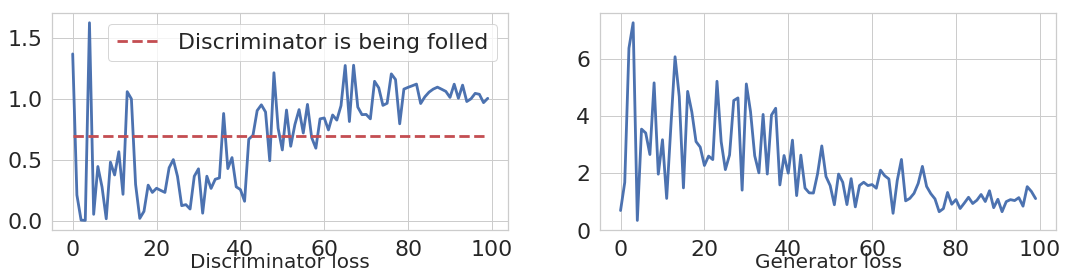

In [262]:
figsize = (18, 4)
fig, axs = plt.subplots(1, 2, figsize=figsize)


# First plot the loss, and then the derivative.
axs[0].plot(disc_losses, '-')
axs[0].plot([np.log(2)] * len(disc_losses), 'r--', label='Discriminator is being folled')
axs[0].legend()
axs[0].set_title('Discriminator loss', fontsize=20, y=-0.2)
axs[1].plot(gen_losses, '-')
axs[1].set_title('Generator loss', fontsize=20, y=-0.2)

### Generate and plot samples and latent interpolations

In [0]:
real_data_vals, final_samples_vals  = sess.run([real_data, samples])

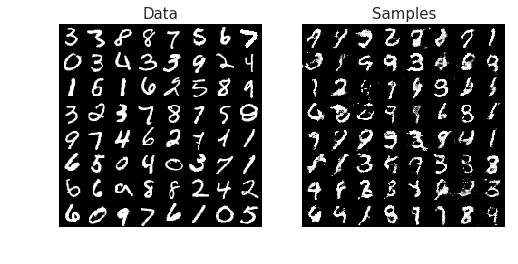

In [264]:
fig, axes = plt.subplots(1, 2, figsize=(2*4,4))

show_digits(axes[0], real_data_vals, 'Data')
show_digits(axes[1], final_samples_vals, 'Samples')

In [0]:
show_latent_interpolations(generator, prior, sess)

## Q2.2 GAN Questions (25 pts):  
1.  **[3 pts]** In defining the optimization procedure above (Section **Create optimizers and training ops**) we opted for two optimizer one for the discriminator and one for the generator. Is this necessary? Why would this be a good/bad idea in general? 

It is not necessary, but generally preferable as we can indepently optimize the discriminator and the generators hyperparameters. The optimization process will not get into local minima that easily as the number of parameters we can optimize for is higher and might change the output a lot.

2.  **[3 pts]** Discuss the hyperparameter sensitivy of GANs compared to that of VAEs. (What happens to the model if you use a higher learning rate for the discriminator or the generator?)

Compared to VAEs GANs sensitivity to a hyperparameter change is very high. With a higher learning rate different things could happen, including model collapse, no convergence and even overfitting can get a big problem.

3.  **[2 pts]** When would you want to use GANs and when would you want to use VAEs? Which of the following can be performed using VAEs, and which can be performed using GANs: density estimation, representation learning, data generation?

If a GAN or VAE is better to use highly depends on the problem you are facing.

Densitiy estimation: VAE
Representation Learning: VAE
Data generation: GAN, VAE

4.  **[2 pts]** What do you observe about GAN samples compared to VAE samples?

GAN samples sometimes are very bad and just random noise, but other samples are really good and show proper digits.

To compare them I would say GAN samples are either very good or bad and VAEs are more average numbers which don't look that real but on average might be a little better.

5.  **[3 pts]** What happens if you optimize the GAN discriminator 5 times per generator update? (This will become particularly relevant for next part) 

It might be the case that the discriminator overrules the generator, as it will be optimized 5  more times per generator update. The result would be that the generator gradient vanishes.

6.  **[2 pts]** What happens if you optimize the GAN generator 10 times per discriminator update?

The generator would easier find a sample to fool the discriminator and as a general result of that the model might not train anything with this model.

**[10 pts] Model Implementation and Results**


# ===== END OF GRADED COURSEWORK ========

## T2.2 [Optional] Wasserstein GAN

Since the proposal of the original GAN, multiple objectives have been proposed, inspired by different learning principles. In Wasserstein GAN, optimal transport is used to create the training criteria:
\begin{equation}
  \sup_{||f||_{L \leq 1}} \mathbb{E}_{p^*(x)} f(x) - \mathbb{E}_{p_(z)} f(G(z))
\end{equation}
where $||f||_{L \leq 1}$ denotes the family of 1-Lipchitz functions.

Due to the intractability of the supremum in the equation above, the WGAN value function is constructed from the optimal transport criteria using the Kantorovich-Rubinstein duality:
\begin{equation}
  \min_{G} \max_{D}  \mathbb{E}_{p^*(x)} D(x) - \mathbb{E}_{p_(z)} D(G(z))
\end{equation}

where $D$ is a 1-Lipchitz function. The Lipchitz constraint is imposed using gradient penalties on the discriminator. 

For extra reading, see:
 * https://arxiv.org/abs/1701.07875
 * https://arxiv.org/abs/1704.00028


**Task**: Implement and train this model to generate MNIST digits. Visualise the results and answer the questions at the end of the section.

## Model Implementation

In [0]:
tf.reset_default_graph()

### Define the gradient penalty

In [0]:
def batch_l2_norms(x, eps=1e-5):
  reduction_axis = range(1, x.get_shape().ndims)
  squares = tf.reduce_sum(tf.square(x), axis=reduction_axis)
  squares.get_shape().assert_is_compatible_with([None])
  return tf.sqrt(eps + squares)

def wgan_gradient_penalty(discriminator, real_data, samples):
  """The gradient penalty loss on an interpolation of data and samples.

  Proposed by https://arxiv.org/pdf/1704.00028.pdf for Wasserstein GAN, but
  recently becoming more widely adopted, outside the Wasserstein setting.

  Args:
    discriminator: An instance of `AbstractDiscriminator`.
    real_data: A `tf.Tensor` (joint discriminator `tf.Tensor` sequences are not
      yet supported). The data associated as real by the GAN, usually from a
      datasets. Needs to be a valid input for `discriminator`.
    samples: A `tf.Tensor` or `tf.Tensor` sequence (for joint discriminators).
      Samples obtained from the model. Needs to be a valid input for
      `discriminator`.

  Returns:
    A `tf.Tensor` scalar, containing the loss.
  """

  ##################
  # YOUR CODE HERE #
  ##################

### Get and rescale the data

Scale the data between -1 and 1. This helps training stability and improves GAN convergence.

In [0]:
real_data = make_tf_data_batch(mnist.train.images)
real_data = 2 * real_data - 1

### Generate samples

In [0]:
##################
# YOUR CODE HERE #
##################
# samples = 

## Set up the adversarial game

### Discriminator and generator loss

In [0]:
# The weight of the gradient penalty
GRADIENT_PENALTY_COEFF = 10

In [0]:
##################
# YOUR CODE HERE #
##################
# discriminator_loss = 
# generator_loss = 

### Create optimizers and training ops



In [0]:
discrimiantor_optimizer = tf.train.AdamOptimizer(0.0001, beta1=0.5, beta2=0.9)
generator_optimizer = tf.train.AdamOptimizer(0.0001, beta1=0.5, beta2=0.9)

# Optimize the discrimiantor.
discriminator_vars =  tf.get_collection(
    tf.GraphKeys.TRAINABLE_VARIABLES, scope=DISCRIMINATOR_VARIABLE_SCOPE)
discriminator_update_op = discrimiantor_optimizer.minimize(
    discriminator_loss, var_list=discriminator_vars)

# Optimize the generator.
generator_vars =  tf.get_collection(
    tf.GraphKeys.TRAINABLE_VARIABLES, scope=GENERATOR_VARIABLE_SCOPE)
generator_update_op = generator_optimizer.minimize(
    generator_loss, var_list=generator_vars)

## Training

We train the discriminator and generator by alternating gradient descent runs. We record the losses to plot them later.

### Create the tensorflow session

In [0]:
sess = tf.Session()

# Initialize all variables
sess.run(tf.global_variables_initializer())

In [0]:
NUM_DISC_UPDATES_PER_GEN_UPDATE = 5

In [0]:
# %hide_pyerr  # - uncomment to interrupt training without a stacktrace
disc_losses = []
gen_losses = []

for i in xrange(TRAINING_STEPS):
  # Do multiple discriminator updates per generator update. 
  for _ in xrange(NUM_DISC_UPDATES_PER_GEN_UPDATE):
    sess.run(discriminator_update_op)
  sess.run(generator_update_op)
  
  if i % 100 == 0: 
    disc_loss = sess.run(discriminator_loss)
    gen_loss = sess.run(generator_loss)    
  
    print('Iteration: {}. Disc loss: {}. Generator loss {}'.format(
          i, disc_loss, gen_loss))
    disc_losses.append(disc_loss)
    gen_losses.append(gen_loss)

## Results

### Visualize the behaviour of the two losses during training

Note that unlike losses for classifiers, or for VAEs, the losses are not stable and are going up and down, depending on the training dynamics. 

In [0]:
figsize = (20, 6)
fig, axs = plt.subplots(1, 2, figsize=figsize)


# First plot the loss, and then the derivative.
axs[0].plot(disc_losses, '-')
axs[0].plot([0.] * len(disc_losses), 'r--', label='Discriminator is being folled')
axs[0].legend()
axs[0].set_title('Discriminator loss', fontsize=20, y=-0.2)
axs[1].plot(gen_losses, '-')
axs[1].set_title('Generator loss', fontsize=20, y=-0.2)

### Generate samples and latent interpolations

In [0]:
real_data_vals, final_samples_vals  = sess.run([real_data, samples])

In [0]:
fig, axes = plt.subplots(1, 2, figsize=(2*4,4))


show_digits(axes[0], real_data_vals, 'Data')
show_digits(axes[1], final_samples_vals, 'Samples')

In [0]:
show_latent_interpolations(generator, prior, sess)

## Questions about WGANs:

* What happens if you optimize the original GAN discriminator 5 times per generator update - like in Wasserstein GANs? What happens if you train the Wassterstein GAN with 1 discriminator update per generator update?
* Can you think of a general recipe to create a new type of GAN loss?
